In [2]:
# Vamos a aplicar Grover para encontrar las trazas posibles en una detección de 4 capas. 
# Consideramos cada capa del detector como
# |0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15 
# Dada una combinacion de hits (h1,h2,h3,h4) candidatos a ser traza, comprobamos que 
# m1=h1+h4 = h2+h3=m2 
# La representación en binario de estas dos sumas es m1=(x1x2x3x4x5), m2=(y1y2y3y4y5), y estos dígitos son los que introducimos como qubits

import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle

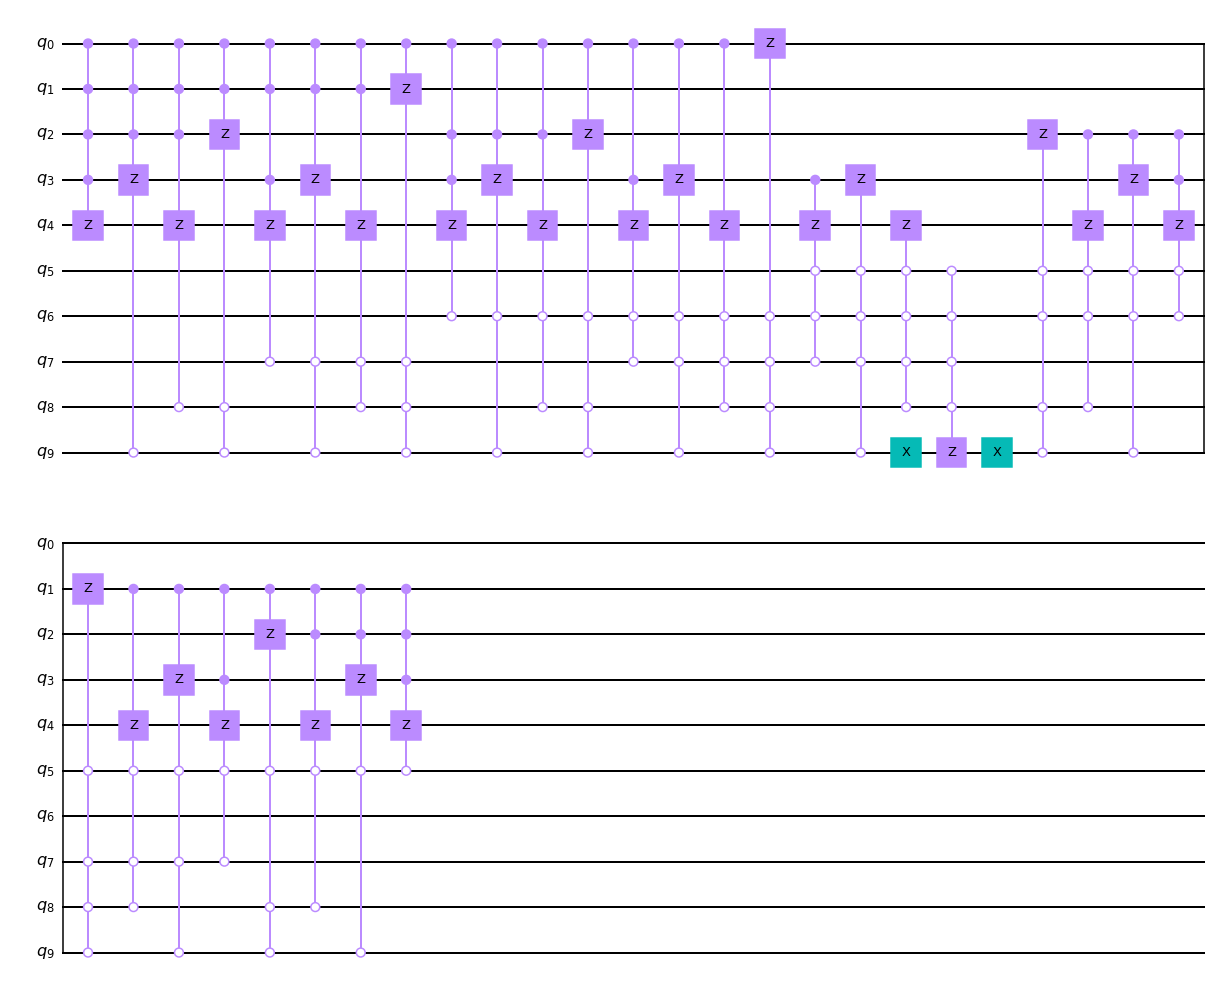

In [25]:


oracle = PhaseOracle('(x1|~x1)&(x2|~x2)&(x3|~x3)&(x4|~x4)&(x5|~x5)&((x1&y1)|(~x1&~y1))&((x2&y2)|(~x2&~y2))&((x3&y3)|(~x3&~y3))&((x4&y4)|(~x4&~y4))&((x5&y5)|(~x5&~y5))')
oracle.draw(output='mpl')

In [26]:
with open('tracking16.dimacs', 'r') as f:
    dimacs = f.read()
print(dimacs)


c example DIMACS-CNF 10-SAT
p cnf 10 10
-6 1
-1 6
-7 2
-2 7
-8 3
-3 8
-9 4
-4 9
-10 5
-5 10



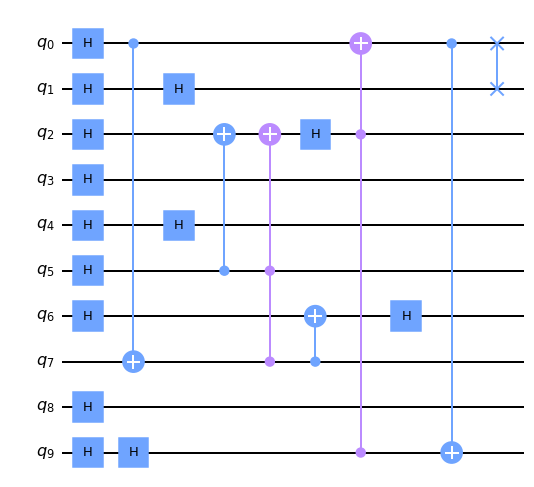

In [41]:
# Preparamos los estados que nos interesan segun las medidas del detector

state_preparation = QuantumCircuit(10)
state_preparation.h([0,1,2,3,4,5,6,9])
state_preparation.cx(0,7)
state_preparation.h([4,9])
state_preparation.cx(5,2)
state_preparation.ccx(7,5,2)
state_preparation.h([1,2,8])
state_preparation.ccx(9,2,0)
state_preparation.cx(7,6)
state_preparation.cx(0,9)
state_preparation.h(6)
state_preparation.swap(0,1)
#state_preparation.measure([0,1,2,3,4,5,6,7,8,9],[0,1,2,3,4,5,6,7,8,9]) # descomentar para aplicar el histograma siguiente y ver qué estados prepara
state_preparation.draw(output='mpl')



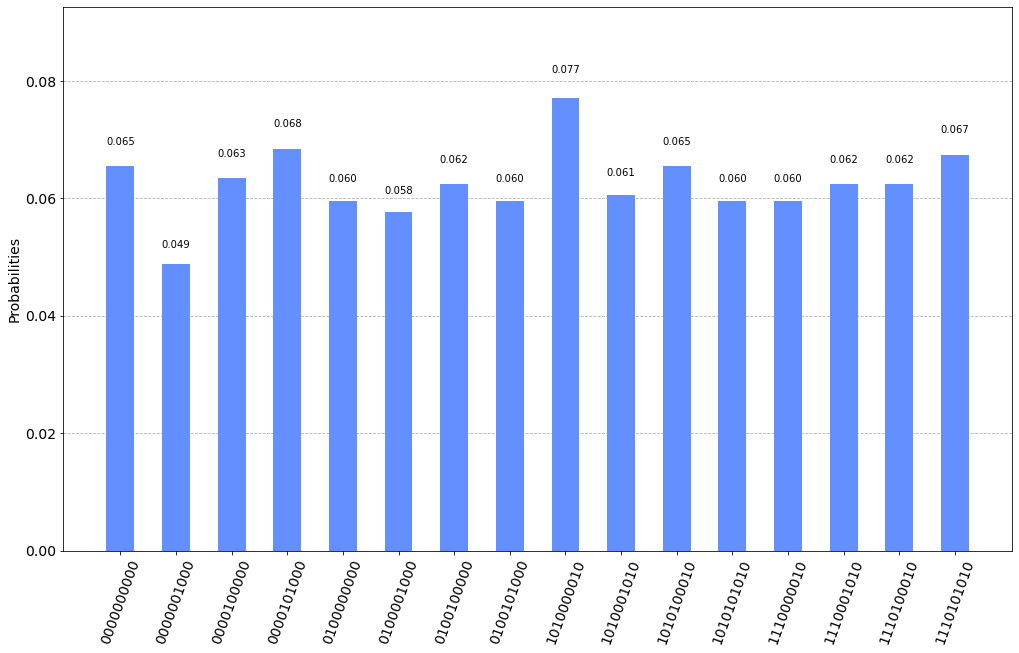

In [40]:
# Aquí deberíamos obtener los vectores (x1x2x3x4y1y2y3y4) propios de nuestras medidas para que tenga sentido lo que estamos haciendo.
# Asimismo, deberiamos obtener las mismas amplitudes, aproximadamente.

aer_sim = Aer.get_backend('aer_simulator')
shots = 500
qobj = assemble(state_preparation, aer_sim)
results = aer_sim.run(qobj).result()

plot_histogram(results.get_counts(),figsize=(17,10))


In [28]:

class Verifier():
    """Create an object that can be used to check whether
    an assignment satisfies a DIMACS file.
        Args:
            dimacs_file (str): path to the DIMACS file
    """
    def __init__(self, dimacs_file):
        with open(dimacs_file, 'r') as f:
            self.dimacs = f.read()

    def is_correct(self, guess):
        """Verifies a SAT solution against this object's
        DIMACS file.
            Args:
                guess (str): Assignment to be verified.
                             Must be string of 1s and 0s.
            Returns:
                bool: True if `guess` satisfies the
                           problem. False otherwise.
        """
        # Convert characters to bools & reverse
        guess = [bool(int(x)) for x in guess]
        
        count=0
        
        
        for line in self.dimacs.split('\n'):
            count=count+1
        
            clause_eval = False
            for literal in line.split(' '):
               
                if literal in ['p', 'c']:
                    # line is not a clause
                    clause_eval = True
                    break
                
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
             
               
                
               
            if clause_eval is False:
                return False
            if count == 12:
                return True
        return True  
            
        

In [31]:
# Vemos si funciona bien o no
v=Verifier('tracking16.dimacs')
v.is_correct('1110111101')

True

In [42]:
# Configure backend
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=2000)



# Con AmplificationProblem podemos decir a grover por donde debe mirar, en este caso por state_preparation

problem = AmplificationProblem(oracle = oracle, state_preparation=state_preparation, is_good_state=v.is_correct)



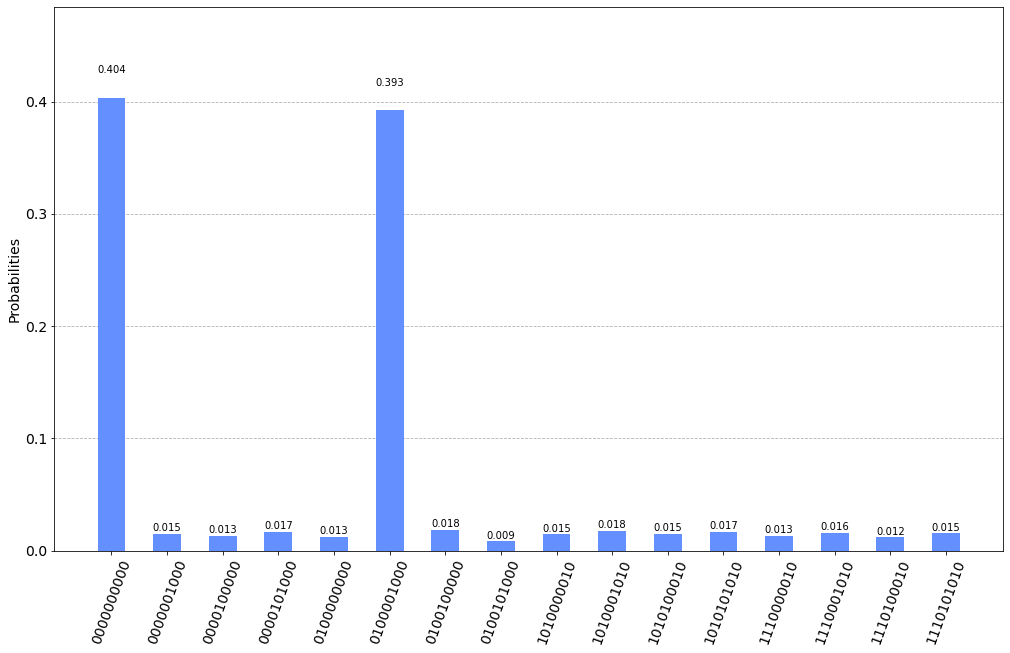

In [43]:

# Usamos grover con los atributos que necesitamos y representamos los resultados.
grover = Grover(quantum_instance=quantum_instance)
result = grover.amplify(problem)
plot_histogram(result.circuit_results[0],figsize=(17,10))


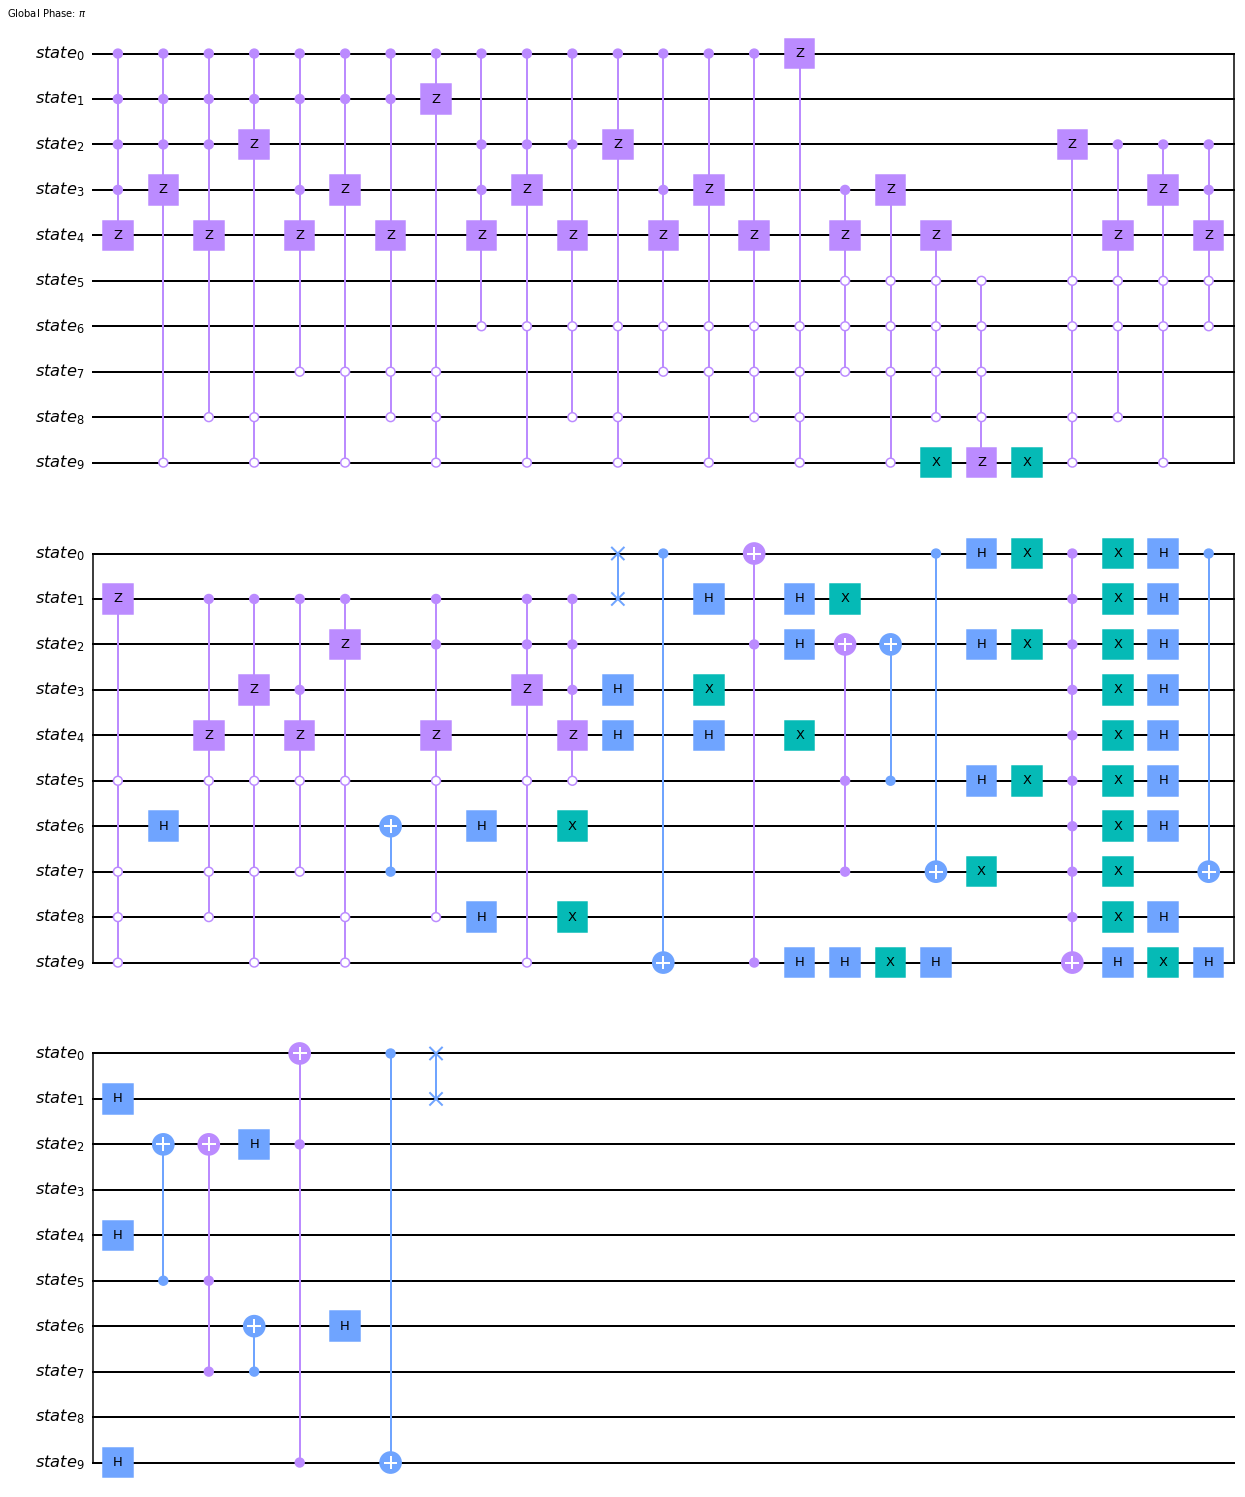

In [44]:
problem.grover_operator.draw(output='mpl')